# 🏍️ LossZero: Motorcycle Night Ride SegFormer-B2 Optimized

이 노트북은 **SegFormer-B2** 모델을 사용하여 야간 오토바이 주행 이미지의 시멘틱 세그멘테이션을 수행합니다.

### 🛠️ 주요 시나리오
- **모델**: SegFormer-B2 (Transformer 기반)
- **백본**: MiT-B2
- **사전 학습**: Cityscapes (도로 환경 특화)
- **최적화**: AdamW + FP16 Mixed Precision
- **손실 함수**: Weighted CrossEntropy (중요 객체 가중치 부여)

In [95]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import wandb

print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.7.1+cu118


## Colab 연결

In [96]:
# from google.colab import drive
# drive.mount('/content/drive')

In [97]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"

    return "cpu"

def num_worker():
    if torch.cuda.is_available():
        return os.cpu_count()

    return 0

# ⚙️ 설정 (Configuration)
# DATA_DIR = "/content/drive/MyDrive/motor_model"
DATA_DIR = "/home/jovyan/work/data/LossZero"
# DATA_DIR = os.path.expanduser("~/Projects/LossZero/data/Motorcycle Night Ride Dataset")
JSON_PATH = os.path.join(DATA_DIR, "COCO_motorcycle (pixel).json")
IMG_DIR = os.path.join(DATA_DIR, "images")

CFG = {
    "project": "LossZero",
    "model_name": "nvidia/segformer-b2-finetuned-cityscapes-1024-1024",
    "img_size": (384, 672),
    "batch_size": 4,
    "lr": 1e-4,
    "epochs": 2,
    "device": get_device(),
    "num_worker": num_worker(),
    "train": True,
    "wndb": True,
}
if CFG["wndb"]:
    wandb.login()

print(f"Using device: {CFG['device']}")
print(f"Data directory: {DATA_DIR}")

Using device: cuda
Data directory: /home/jovyan/work/data/LossZero


In [98]:
def create_mask_from_json(coco, img_id, img_info, id_to_idx):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in anns:
        cat_id = ann['category_id']
        if cat_id in id_to_idx:
            cls_idx = id_to_idx[cat_id]
            pixel_mask = coco.annToMask(ann)
            mask[pixel_mask == 1] = cls_idx

    return mask

def process_single_data(coco, img_id, img_dir, id_to_idx, transform=None):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = create_mask_from_json(coco, img_id, img_info, id_to_idx)

    if transform:
        augmented = transform(image=image, mask=mask)
        image, mask = augmented['image'], augmented['mask']

    return image, torch.as_tensor(mask).long()

train_transform = A.Compose([
    #  원본 해상도에서 480x480 크기로 무작위 추출 (화질 저하 없음)
    A.RandomCrop(height=CFG['img_size'][0], width=CFG['img_size'][1], p=1.0),
    A.PadIfNeeded(min_height=CFG['img_size'][0], min_width=CFG['img_size'][1], p=1.0),

    # --- 야간 전용 Augmentation 추가 ---
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5), # 어두운 저조도 개선
    A.GaussNoise(std_range=(0.02, 0.05), p=0.3), # 야간 노이즈 대응

    # --- 기하학적 변형 (데이터 수 보충용) ---
    A.HorizontalFlip(p=0.5), # 좌우 반전
    # 0.0625는 머신러닝/딥러닝 커뮤니티에서 오랫동안 검증된 '사실상 표준(De Facto Standard)
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.5), # 이동/크기/회전

    # ImageNet 데이타셋의 평균값 나쁘지 않음. SegFormer가 ImageNet/Cityscapes로 배웠으니까
    # 모델이 새로운 사진을 받을 때: 입력_이미지 = (원본_이미지 - 평균) / 표준편차
    # 이렇게 계산해주면, 어떤 사진이 들어와도 "평균이 0이고 표준편차가 1인(Standard Normal Distribution)" 아주 예쁜 데이터로 변신
    # 전체 야간 데이터셋의 Mean/Std를 직접 계산한 값
    A.Normalize(mean=(0.281, 0.268, 0.346), std=(0.347, 0.290, 0.292)),
    ToTensorV2()
])

coco = COCO(JSON_PATH)
img_ids = list(coco.imgs.keys())
cat_ids = coco.getCatIds()
id_to_idx = {cat_id: i for i, cat_id in enumerate(cat_ids)}
print(f"Category Mapping: {id_to_idx}")

loading annotations into memory...
Done (t=2.03s)
creating index...
index created!
Category Mapping: {1329681: 0, 1323885: 1, 1323884: 2, 1323882: 3, 1323881: 4, 1323880: 5}


## Traing / Val 분리

In [99]:
import random
from sklearn.model_selection import train_test_split
class MotorcycleNightRideDataset(Dataset):
    def __init__(self, coco, img_ids, img_dir, id_to_idx, transform=None, use_copy_paste=False):
        self.coco = coco
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.id_to_idx = id_to_idx
        self.transform = transform
        self.use_copy_paste = use_copy_paste  # Copy-Paste 활성화 여부 (Train만 True)

    def __len__(self):
        return len(self.img_ids)

    def load_image_mask(self, idx):
        """인덱스에 해당하는 이미지와 마스크를 로드하고 BGR->RGB 변환"""
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 마스크 생성 (기존 함수 활용)
        mask = create_mask_from_json(self.coco, img_id, img_info, self.id_to_idx)
        return image, mask

    def apply_copy_paste(self, image, mask):
        """
        Copy-Paste Augmentation:
        다른 이미지(Donor)에서 'Lane Mark(3)'나 'Moveable(2)' 같은 소수 클래스를 오려내어
        현재 이미지(Target)에 붙여넣습니다.
        """
        # 1. 기증자(Donor) 무작위 선택
        donor_idx = random.randint(0, len(self.img_ids) - 1)
        donor_img, donor_mask = self.load_image_mask(donor_idx)

        # 2. 오려낼 타겟 클래스 정의 (차선과 움직이는 물체 집중 공략)
        # Lane Mark: 3, Moveable: 2
        target_indices = [2, 3]

        # donor_mask에서 해당 클래스인 픽셀만 True (나머지 False)
        # np.isin을 사용하여 여러 클래스를 한 번에 처리
        paste_mask = np.isin(donor_mask, target_indices)

        # 3. 붙여넣기 (Paste)
        # 해당 영역에 내용물이 있을 경우에만 실행
        if np.any(paste_mask):
            # 이미지 덮어쓰기
            image[paste_mask] = donor_img[paste_mask]
            # 마스크 덮어쓰기 (정답지 수정)
            mask[paste_mask] = donor_mask[paste_mask]

        return image, mask

    def __getitem__(self, idx):
        # 1. 원본 데이터 로드
        image, mask = self.load_image_mask(idx)

        # 2. Copy-Paste 적용 (훈련 데이터셋이고, 50% 확률 당첨 시)
        if self.use_copy_paste and random.random() < 0.5:
            image, mask = self.apply_copy_paste(image, mask)

        # 3. Albumentations 변환 (Resize, ColorJitter, Normalization 등)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, torch.as_tensor(mask).long()

# --------------------------------------------------------------------------
# 1. 데이터 로드 및 ID 분할 (7:2:1)
coco = COCO(JSON_PATH)
all_ids = list(coco.imgs.keys())

# First split: 70% train, 30% temp
train_ids, temp_ids = train_test_split(all_ids, test_size=0.3, random_state=42)
# Second split: temp_ids into 2/3 for val (0.2 of total), 1/3 for test (0.1 of total)
val_ids, test_ids = train_test_split(temp_ids, test_size=1/3, random_state=42)

# 2. Transform 정의 (기존 정의 활용)
val_transform = A.Compose([
    A.Resize(CFG['img_size'][0], CFG['img_size'][1]),
    A.Normalize(mean=(0.281, 0.268, 0.346), std=(0.347, 0.290, 0.292)),
    ToTensorV2()
])
# Test transform is the same as validation transform
test_transform = val_transform

# 3. 데이터셋 인스턴스 생성 (★Train에만 Copy-Paste 활성화★)
train_dataset = MotorcycleNightRideDataset(
    coco, train_ids, IMG_DIR, id_to_idx,
    transform=train_transform,
    use_copy_paste=True  # Copy-Paste ON!
)
val_dataset = MotorcycleNightRideDataset(
    coco, val_ids, IMG_DIR, id_to_idx,
    transform=val_transform,
    use_copy_paste=False # Val에는 절대 쓰면 안 됨 (순수 평가)
)
test_dataset = MotorcycleNightRideDataset( # New test dataset
    coco, test_ids, IMG_DIR, id_to_idx,
    transform=test_transform,
    use_copy_paste=False # Test에는 절대 쓰면 안 됨 (순수 평가)
)

# 4. 데이터 로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=CFG['num_worker'],
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_worker'],
    pin_memory=True
)
test_loader = DataLoader( # New test loader
    test_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_worker'],
    pin_memory=True
)

# Define CFG_EVAL for later use
CFG_EVAL = {
    "num_classes": len(id_to_idx)
}

print(f"✅ Data Ready with Copy-Paste Augmentation!")
print(f"   Train={len(train_ids)} (CP Active), Val={len(val_ids)}, Test={len(test_ids)}")

loading annotations into memory...
Done (t=2.09s)
creating index...
index created!
✅ Data Ready with Copy-Paste Augmentation!
   Train=140 (CP Active), Val=40, Test=20


### 📉 클래스별 분포 요약 (내림차순)

1. **Undrivable (주행 불가 영역)**: **42.9%** (압도적 1위)
   - 배경(하늘, 건물, 풀숲 등)이 이미지의 절반 가까이 차지합니다.
2. **Road (주행 가능 도로)**: **27.1%**
   - 도로 자체도 꽤 많은 영역을 차지합니다.
3. **My bike (내 오토바이)**: **15.8%**
   - 주행자 시점이라 내 오토바이가 항상 보이기 때문에 비율이 높습니다.
4. **Rider (탑승자)**: **8.1%**
   - 다른 오토바이 운전자나 내 신체가 포함된 것으로 보입니다.
5. **Moveable (이동 물체)**: **4.7%**
   - 다른 차량, 보행자 등 안전에 가장 중요한 장애물인데 비율이 매우 낮습니다.
6. **Lane Mark (차선)**: **1.4%**
   - 가장 심각한 불균형입니다. 도로 주행의 핵심인 차선이 고작 1% 남짓입니다.

In [100]:
id2label = {i: coco.loadCats(cat_id)[0]['name'] for cat_id, i in id_to_idx.items()}
label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG['lr'], # Learning Rate
    weight_decay=0.05 #가중치의 관성 제어, 옵티마이저에서 0.01이라는 값은 매 학습 단계(Step)마다 현재 가중치 값을 얼마나 깎을지를 결정하는 비율입니다.
)

# ⚖️ 클래스별 가중치 설정 (Class Weights)
weights = torch.tensor([
    3.0,   # Rider: 5.0 → 3.0 (중요하지만 과하지 않게)
    1.5,   # My bike: 2.0 → 1.5 (내 오토바이는 너무 잘 맞히니 조금 더 낮춤)
    6.0,   # Moveable: 10.0 → 6.0 (절반으로 줄여서 부담 완화)
    12.0,  # Lane Mark: 20.0 → 12 (여전히 제일 강력하지만, 20배는 너무 가혹했음)
    1.0,   # Road: 1.0 (기준점 유지)
    0.8    # Undrivable: 0.5 → 0.8 (배경을 너무 무시해서 도로 경계가 무너지는 것 방지)
], dtype=torch.float).to(CFG['device'])

criterion = nn.CrossEntropyLoss(weight=weights)

scaler = GradScaler('cuda') if CFG['device'] == 'cuda' else None

Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


In [101]:
import torch
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix

# [1] 기본 IoU 계산 로직 (Category-specific)
def compute_category_iou(preds, targets, num_classes):
    preds_flat = preds.flatten().cpu().numpy()
    targets_flat = targets.flatten().cpu().numpy()
    valid_mask = (targets_flat >= 0) & (targets_flat < num_classes)
    preds_flat = preds_flat[valid_mask]
    targets_flat = targets_flat[valid_mask]
    cm = confusion_matrix(targets_flat, preds_flat, labels=range(num_classes))
    intersection = np.diag(cm)
    ground_truth_set = cm.sum(axis=1)
    predicted_set = cm.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    iou = intersection / (union + 1e-6)
    return iou

# [2] Boundary IoU 계산 로직
def get_boundary(mask, dilation_pixels=2):
    mask = mask.astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=dilation_pixels)
    boundary = mask - eroded
    return boundary

def compute_boundary_iou(preds, targets, num_classes, dilation_pixels=2):
    preds_np = preds.cpu().numpy()
    targets_np = targets.cpu().numpy()
    b_ious = []
    for c in range(num_classes):
        class_preds = (preds_np == c)
        class_targets = (targets_np == c)
        ious_per_batch = []
        for i in range(preds_np.shape[0]):
            gt_boundary = get_boundary(class_targets[i], dilation_pixels)
            pred_boundary = get_boundary(class_preds[i], dilation_pixels)
            intersection = ((gt_boundary > 0) & (pred_boundary > 0)).sum()
            union = ((gt_boundary > 0) | (pred_boundary > 0)).sum()
            if union == 0:
                ious_per_batch.append(1.0)
            else:
                ious_per_batch.append(intersection / union)
        if not ious_per_batch:
            b_ious.append(0.0)
        else:
            b_ious.append(np.mean(ious_per_batch))
    return np.array(b_ious)

# [3] 통합 평가 함수 (Metrics Calculation)
def evaluate_metrics(preds, targets, num_classes):
    """예측값과 정답을 받아 모든 지표(Category IoU, Boundary IoU)를 한 번에 계산"""
    cat_iou = compute_category_iou(preds, targets, num_classes)
    bound_iou = compute_boundary_iou(preds, targets, num_classes)
    return cat_iou, bound_iou

# [4] 상세 리포트 출력 함수 (Report Generation)
def print_evaluation_report(avg_cat_iou, avg_bound_iou, id2label=None):
    """계산된 평균 IoU 값들을 받아 보기 좋게 출력"""
    print("\n[Validation Report]")
    print("  Category-specific IoU:")
    for i, iou in enumerate(avg_cat_iou):
        label = id2label[i] if id2label else f"Class {i}"
        print(f"    - {label}: {iou:.4f}")

    print("\n  Boundary IoU (Details):")
    for i, iou in enumerate(avg_bound_iou):
        label = id2label[i] if id2label else f"Class {i}"
        print(f"    - {label}: {iou:.4f}")

    mIoU = np.nanmean(avg_cat_iou)
    mBoU = np.nanmean(avg_bound_iou)
    print(f"\n  --> mIoU: {mIoU:.4f} | mBoU: {mBoU:.4f}\n")
    return mIoU, mBoU


In [102]:
# [공통 로직] 데이터 전송, 추론, 확대, 손실 계산
def forward_step(model, images, masks, criterion, device):
    # 데이터를 GPU(CUDA) 또는 CPU 중 실제 연산이 일어날 장치로 보낸다
    # torch.Tensor 형태이며 contiguous()로 메모리를 정렬한다
    X = images.to(device).contiguous()
    y = masks.to(device).contiguous()

    # Forward Pass
    # logits: 우리가 찾는 클래스별 점수판 (필수!) -10.5나 15.2 같은 자유로운 숫자
    outputs = model(X).logits

    # 확대 (Interpolation)
    # 모델 결과물(outputs)은 연산 효율을 위해 96x96으로 축소되어 있음
    # 이를 정답지 y와 똑같은 크기(384x384)로 부드럽게 확대(Interpolate)
    # y.shape[-2:] -> (384, 384)
    upsampled_logits = nn.functional.interpolate(
        outputs, size=y.shape[-2:], mode="bilinear", align_corners=False
    )

    # 오차(Loss) 계산
    loss = criterion(upsampled_logits, y)

    return loss, upsampled_logits, y

# [학습 단계] 한 에폭 동안의 학습 집행
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None, epoch=0):
    model.train()
    train_loss_sum = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Train]")

    for images, masks in pbar:
        optimizer.zero_grad()

        # Mixed Precision 지원 (CUDA 전용)
        if device == 'cuda' and scaler:
            with torch.amp.autocast('cuda'):
                loss, _, _ = forward_step(model, images, masks, criterion, device)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # 역전파 및 가중치 업데이트
            loss, _, _ = forward_step(model, images, masks, criterion, device)
            loss.backward()
            optimizer.step()

        # 모델이 예측한 값과 정답 사이의 거리 기록
        train_loss_sum += loss.item()
        pbar.set_postfix(Loss=f"{loss.item():.4f}")

    return train_loss_sum / len(loader)

# [검증 단계] 모듈화된 평가 로직 적용
def validate(model, loader, criterion, device, num_classes=6, id2label=None):
    model.eval()
    val_loss_sum = 0

    # 지표 누적용 배열 (Total Accumulators)
    total_cat_ious = np.zeros(num_classes)
    total_bound_ious = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in loader:
            # 1. 공통 로직 실행 (Loss 계산)
            loss, logits, y = forward_step(model, images, masks, criterion, device)
            val_loss_sum += loss.item()

            # 2. 예측값 변환
            preds = torch.argmax(logits, dim=1)

            # 3. 통합 평가 모듈 호출
            cat_iou, bound_iou = evaluate_metrics(preds, y, num_classes)
            total_cat_ious += cat_iou
            total_bound_ious += bound_iou

    # 에폭 평균 계산
    avg_loss = val_loss_sum / len(loader)
    avg_cat_iou = total_cat_ious / len(loader)
    avg_bound_iou = total_bound_ious / len(loader)

    # 4. 상세 리포트 출력 모듈 호출
    mIoU, mBoU = print_evaluation_report(avg_cat_iou, avg_bound_iou, id2label)

    return avg_loss, mIoU, mBoU



In [103]:
# --- 🚀 메인 학습 루프 (Auto-Save 기능 탑재) ---
print("🚀 SegFormer-B2 Training Start with Dual Auto-Save Strategy...")
if CFG["train"]:
    if CFG["wndb"]:
        wandb.init(project=CFG['project'], config=CFG)
    
    best_miou = 0.0
    best_mbou = 0.0
    best_miou_epoch = 0
    
    save_dir = "./checkpoints"
    os.makedirs(save_dir, exist_ok=True)
    
    for epoch in range(CFG['epochs']):
        # 1. 학습 실행
        avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion, CFG['device'], scaler, epoch)
    
        # 2. 검증 실행
        avg_val_loss, avg_val_miou, avg_val_mbou = validate(model, val_loader, criterion, CFG['device'], num_classes=6, id2label=id2label)
    
        if CFG["wndb"]:
            wandb.log({'Train Loss': avg_train_loss, 'Val Loss': avg_val_loss, 'epoch': epoch})
    
    
        print(f"📝 Epoch [{epoch+1}/{CFG['epochs']}]")
        print(f"   Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"   ✨ Val mIoU: {avg_val_miou:.4f} | mBoU: {avg_val_mbou:.4f}")
    
        # --------------------------------------------------------------------------
        # 💾 3. 이중 자동 저장 (Dual Auto-Save)
        # --------------------------------------------------------------------------
        # [기준 1] mIoU 챔피언 (가장 똑똑한 모델)
        if avg_val_miou > best_miou:
            print(f"   🏆 New Best mIoU! ({best_miou:.4f} -> {avg_val_miou:.4f}) Saving...")
            best_miou = avg_val_miou
            best_miou_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "segformer_best_miou.pth"))
    
        # [기준 2] mBoU 챔피언 (테두리 장인)
        if avg_val_mbou > best_mbou:
            print(f"   🎨 New Best mBoU! ({best_mbou:.4f} -> {avg_val_mbou:.4f}) Saving...")
            best_mbou = avg_val_mbou
            torch.save(model.state_dict(), os.path.join(save_dir, "segformer_best_mbou.pth"))
    
        # 0.5 수준: "기반은 닦았으나, 고득점 문제는 포기한 상태"
        # 0.1 수준: "실전에 투입해볼 만한 우등생"
        # 0.01 수준: "완벽, 혹은 너무 과한 공부(과적합)"
        print("-" * 50)
    
    print(f"\n🎉 Training Complete!")
    print(f"   👑 Overall Best mIoU: {best_miou:.4f} (at Epoch {best_miou_epoch})")
    print(f"   🖌️ Overall Best mBoU: {best_mbou:.4f}")
    # 마지막 상태도 저장
    torch.save(model.state_dict(), os.path.join(save_dir, "segformer_last.pth"))
    
    if CFG["wndb"]:
        wandb.finish()

🚀 SegFormer-B2 Training Start with Dual Auto-Save Strategy...


### 🛠️ 주요 평가 항목
- **mIoU** (Mean Intersection over Union):
  - **Category-specific IoU**
  - **Boundary IoU**
- **실시간성 및 하드웨어 지표**
  - **Model Parameters**
  - **MACs** Multiply-Accumulate Operations
    - y = wx + b 에서 wx + b를 1MAC 이라고 한다.
  - **GFLOPs** Giga Floating Point Operations
    -  모델을 한 번 실행(Forward Pass)할 때 필요한 총 부동 소수점 연산량
    - 보통 1MAC = 2FLOPs
  - **Average Inference Latency**
  - **Frames Per Second (FPS)**
- **Safety-critical Metrics**

- TODO
  - 테스트 이미지로 평가할 것 ( 현재는 전체 이미지 SET 사용 )

In [104]:
import time
from thop import profile

def profile_model(model, img_size, device):
    print(f"🚀 Starting Model Profiling for: {model.__class__.__name__}...")

    # 모델을 평가 모드로 설정
    model.eval()

    # 2. 모델을 위한 더미 입력 텐서 생성
    dummy_input = torch.randn(1, 3, img_size[0], img_size[1]).to(device)

    # 3. 더미 입력을 사용하여 모델의 MACs 및 매개변수(params)를 계산하기 위해 thop.profile 사용. verbose=False로 설정.
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)

    # 4. 계산된 MACs를 1e9로 나누어 GFLOPs로 변환.
    gflops = (macs * 2) / 1e9

    print(f"  Model Parameters (M): {params / 1e6:.2f}")
    print(f"  MACs (G): {macs / 1e9:.2f}")
    print(f"  GFLOPs: {gflops:.2f}")

    # 5. 지연 시간 및 FPS 측정을 위한 변수 초기화.
    num_warmup_runs = 10
    num_inference_runs = 100
    total_latency = 0.0

    # 6. 워밍업 실행 수행
    # print(f"  Performing {num_warmup_runs} warm-up runs...")
    with torch.no_grad():
        for _ in range(num_warmup_runs):
            _ = model(dummy_input)

    # 7. 추론 지연 시간 측정
    # print(f"  Measuring latency over {num_inference_runs} inference runs...")
    with torch.no_grad():
        for _ in range(num_inference_runs):
            start_time = time.perf_counter()
            _ = model(dummy_input)
            end_time = time.perf_counter()
            total_latency += (end_time - start_time)

    # 8. 평균 지연 시간(ms) 계산
    average_latency_ms = (total_latency / num_inference_runs) * 1000

    # 9. FPS 계산
    fps = 1000 / average_latency_ms

    print(f"  Average Inference Latency: {average_latency_ms:.2f} ms")
    print(f"  Frames Per Second (FPS): {fps:.2f}")

In [105]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class SafetyEvalMetrics:
    def __init__(self, num_classes, class_names):
        self.num_classes = num_classes
        self.class_names = class_names
        self.confusion_matrix = np.zeros((num_classes, num_classes))

    def update(self, preds, gts):
        """
        한 배치(Batch) 또는 한 프레임의 결과를 누적합니다.
        preds, gts: [Batch, H, W] 형태의 Tensor 또는 Numpy
        """
        preds = preds.flatten()
        gts = gts.flatten()

        # 유효하지 않은 타겟 값 제외 (예: 패딩 또는 ignore_index가 포함된 경우)
        valid_mask = (gts >= 0) & (gts < self.num_classes)
        preds = preds[valid_mask]
        gts = gts[valid_mask]

        # sklearn의 confusion_matrix를 사용하여 매트릭스 업데이트
        # labels 인자를 명시적으로 제공하여 모든 클래스가 포함되도록 보장
        new_cm = confusion_matrix(gts, preds, labels=range(self.num_classes))
        self.confusion_matrix += new_cm

    def plot_confusion_matrix(self, normalize=True):
        """
        혼동 행렬 시각화
        """
        cm = self.confusion_matrix
        if normalize:
            # 행(Actual) 기준 정규화: 해당 클래스가 실제 무엇으로 예측되었는지 비율 확인
            # 0으로 나누는 오류 방지를 위해 1e-9 추가
            cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                    cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)

        plt.title('Road Scene Segmentation: Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('Ground Truth Label')
        plt.show()

    def analyze_safety_risks(self):
        """
        치명적 오분류(Safety-Critical) 집중 분석
        """
        cm_norm = self.confusion_matrix.astype('float') / (self.confusion_matrix.sum(axis=1)[:, np.newaxis] + 1e-9)

        print("\n=== [Safety-Critical Analysis] ===")

        try:
            rider_idx = self.class_names.index('Rider')
            mybike_idx = self.class_names.index('My bike')
            moveable_idx = self.class_names.index('Moveable')
            lanemark_idx = self.class_names.index('Lane Mark')
            road_idx = self.class_names.index('Road')
            undrivable_idx = self.class_names.index('Undrivable')

            print("--- 고위험 ---")
            undrivable_as_road = cm_norm[undrivable_idx, road_idx]
            print(f"1. 즉각적인 충돌 위험 - Undrivable -> Road로 오분류 : {undrivable_as_road:.2%}")

            missed_moveable_as_undrivable = cm_norm[moveable_idx, undrivable_idx]
            print(f"2. 이동 물체 충돌 위험 - Moveable -> Undrivable로 오분류 : {missed_moveable_as_undrivable:.2%}")

            missed_moveable_as_road = cm_norm[moveable_idx, road_idx]
            print(f"3. 이동 물체 충돌 위험 - Moveable -> Road로 오분류 : {missed_moveable_as_road:.2%}")

            rider_as_undrivable = cm_norm[rider_idx, undrivable_idx]
            print(f"4. 시스템 오작동 유발 - Rider -> Undrivable로 오분류 : {rider_as_undrivable:.2%}")

            print("\n--- 중위험 ---")
            road_to_undrivable = cm_norm[road_idx, undrivable_idx]
            print(f"5. 경로 계획 오류 - Road -> Undrivable 로 오분류 : {road_to_undrivable:.2%}")

            lanemark_as_road = cm_norm[lanemark_idx, road_idx]
            print(f"6. 차선 유지 보조 오류 - Lane Mark -> Road로 오분류 : {lanemark_as_road:.2%}")

            print("\n--- 낮은-중간 위험 ---")
            rider_as_mybike = cm_norm[rider_idx, mybike_idx]
            print(f"7. 자기 인식 오류 - Rider -> My bike로 오분류 : {rider_as_mybike:.2%}")

        except ValueError as e:
            print(f"오류: 데이터셋의 클래스 이름을 확인하세요: {e}")


In [106]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def run_safety_evaluation(model_to_eval, model_name, val_loader, device, num_classes, id2label):
    print(f"🚀 Starting Safety Evaluation for {model_name}...")

    # Instantiate SafetyEvalMetrics
    class_names = [name for i, name in sorted(id2label.items())]
    evaluator = SafetyEvalMetrics(num_classes=num_classes, class_names=class_names)

    # Evaluate the model on the validation set to update the confusion matrix
    model_to_eval.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            X = images.to(device).contiguous()
            y = masks.to(device).contiguous()

            outputs = model_to_eval(X).logits
            upsampled_logits = nn.functional.interpolate(
                outputs,
                size=y.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            preds = upsampled_logits.argmax(dim=1)
            evaluator.update(preds.cpu().numpy(), y.cpu().numpy())

    # Plot the confusion matrix
    evaluator.plot_confusion_matrix(normalize=True)
    evaluator.analyze_safety_risks()

Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


🚀 Starting Model Profiling for: SegformerForSemanticSegmentation...
  Model Parameters (M): 27.35
  MACs (G): 55.88
  GFLOPs: 111.75
  Average Inference Latency: 56.61 ms
  Frames Per Second (FPS): 17.67


🚀 Starting Model Profiling for: SegformerForSemanticSegmentation...
  Model Parameters (M): 27.35
  MACs (G): 55.88
  GFLOPs: 111.75
  Average Inference Latency: 57.45 ms
  Frames Per Second (FPS): 17.41
🚀 Starting Safety Evaluation for Best mIoU Model...


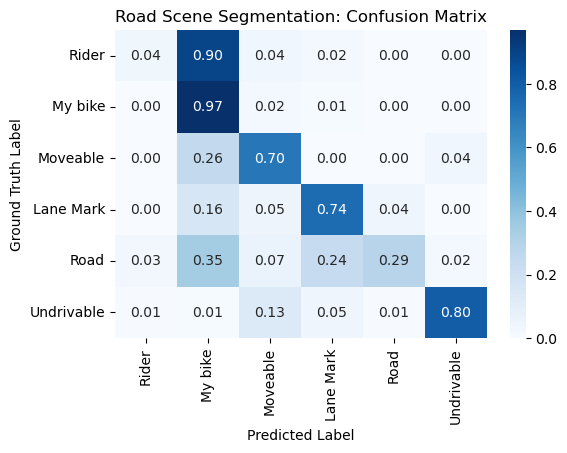


=== [Safety-Critical Analysis] ===
--- 고위험 ---
1. 즉각적인 충돌 위험 - Undrivable -> Road로 오분류 : 0.73%
2. 이동 물체 충돌 위험 - Moveable -> Undrivable로 오분류 : 3.66%
3. 이동 물체 충돌 위험 - Moveable -> Road로 오분류 : 0.00%
4. 시스템 오작동 유발 - Rider -> Undrivable로 오분류 : 0.37%

--- 중위험 ---
5. 경로 계획 오류 - Road -> Undrivable 로 오분류 : 2.42%
6. 차선 유지 보조 오류 - Lane Mark -> Road로 오분류 : 4.43%

--- 낮은-중간 위험 ---
7. 자기 인식 오류 - Rider -> My bike로 오분류 : 89.56%


🚀 Starting Safety Evaluation for Best mBoU Model...


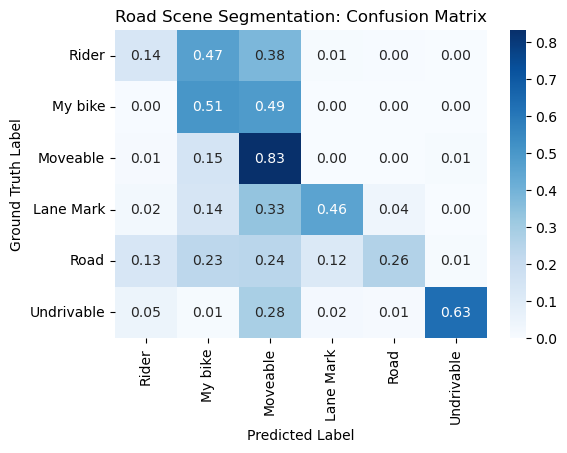


=== [Safety-Critical Analysis] ===
--- 고위험 ---
1. 즉각적인 충돌 위험 - Undrivable -> Road로 오분류 : 1.02%
2. 이동 물체 충돌 위험 - Moveable -> Undrivable로 오분류 : 0.71%
3. 이동 물체 충돌 위험 - Moveable -> Road로 오분류 : 0.01%
4. 시스템 오작동 유발 - Rider -> Undrivable로 오분류 : 0.11%

--- 중위험 ---
5. 경로 계획 오류 - Road -> Undrivable 로 오분류 : 0.92%
6. 차선 유지 보조 오류 - Lane Mark -> Road로 오분류 : 4.17%

--- 낮은-중간 위험 ---
7. 자기 인식 오류 - Rider -> My bike로 오분류 : 46.64%


In [107]:
# Define the path to the saved checkpoints
CHECKPOINTS_DIR = "./checkpoints"

# Recreate the model architecture (it must be the same as during training)
# The configuration `CFG['model_name']`, `id2label`, `label2id`, `num_labels` are from previous cells.

# Model for Best mIoU
model_best_miou = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

# Load the state dictionary for the best mIoU model
miou_checkpoint_path = os.path.join(CHECKPOINTS_DIR, "segformer_best_miou.pth")
model_best_miou.load_state_dict(torch.load(miou_checkpoint_path, map_location=CFG['device']))
model_best_miou.eval()

# Model for Best mBoU
model_best_mbou = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

# Load the state dictionary for the best mBoU model
mbou_checkpoint_path = os.path.join(CHECKPOINTS_DIR, "segformer_best_mbou.pth")
model_best_mbou.load_state_dict(torch.load(mbou_checkpoint_path, map_location=CFG['device']))
model_best_mbou.eval()

# Call the profiling function for model_best_miou
profile_model(model_best_miou, CFG['img_size'], CFG['device'])

print("\n" + "="*50 + "\n") # Separator for clarity

# Call the profiling function for model_best_mbou
profile_model(model_best_mbou, CFG['img_size'], CFG['device'])

# Run safety evaluation for model_best_miou
run_safety_evaluation(
    model_best_miou,
    "Best mIoU Model",
    val_loader,
    CFG['device'],
    CFG_EVAL['num_classes'],
    id2label
)

print("\n" + "="*50 + "\n") # Separator for clarity

# Run safety evaluation for model_best_mbou
run_safety_evaluation(
    model_best_mbou,
    "Best mBoU Model",
    val_loader,
    CFG['device'],
    CFG_EVAL['num_classes'],
    id2label
)